Libraries

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

Data Preparation


In [ ]:
# Loading Kuzushiji-MNIST dataset
dataset, info = tfds.load('kmnist', as_supervised=True, with_info=True)

train_data = dataset['train']
test_data = dataset['test']

# Convert the dataset to NumPy arrays
def convert_to_numpy(data):
    images = []
    labels = []
    for img, label in tfds.as_numpy(data):
        images.append(img)
        labels.append(label)
    return np.array(images), np.array(labels)

x_train, y_train = convert_to_numpy(train_data)
x_test, y_test = convert_to_numpy(test_data)

num_samples = 5000
x_train = x_train[:num_samples]
y_train = y_train[:num_samples]

# Normalize pixel values to [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Flatten the images from 28x28 to 784 (input layer for RBF)
x_train = x_train.reshape(-1, 28 * 28)
x_test = x_test.reshape(-1, 28 * 28)

# Split the training set into training and validation sets (80% train, 20% test)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# One-hot encode the labels for classification
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

print("Data preparation complete!")

Data preparation complete!


Radial Basis Network

o Implement an RBF network using a Gaussian basis function.



In [ ]:
class RBFNetwork(tf.keras.Model):
    def __init__(self, num_rbf_units, num_classes, sigma=1.0):
        super(RBFNetwork, self).__init__()
        self.num_rbf_units = num_rbf_units
        self.num_classes = num_classes
        self.sigma = sigma

        # Initialize RBF layer parameters
        self.centers = None
        self.hidden_weights = None

    def call(self, inputs):
        # Compute the RBF activation (Gaussian function)
        diff = tf.expand_dims(inputs, axis=1) - self.centers  # Compute difference between input and centers
        norm = tf.norm(diff, axis=-1)  # Compute Euclidean distance
        rbf_out = tf.exp(-tf.square(norm) / (2 * self.sigma ** 2))  # Gaussian function

        # Linear output layer with softmax activation
        output = tf.matmul(rbf_out, self.hidden_weights)
        return tf.nn.softmax(output)

# Number of RBF units
num_rbf_units = 100
num_classes = 10

# Initialize the model
model = RBFNetwork(num_rbf_units=num_rbf_units, num_classes=num_classes)
print("RBF Network initialized!")

RBF Network initialized!


Training


In [ ]:
kmeans = KMeans(n_clusters=num_rbf_units, random_state=42)
kmeans.fit(x_train)
model.centers = tf.convert_to_tensor(kmeans.cluster_centers_, dtype=tf.float32)

# Randomly initialize hidden layer weights
model.hidden_weights = tf.Variable(tf.random.normal([num_rbf_units, num_classes], stddev=0.1))

# Define the loss function and optimizer
loss_fn = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

# Training loop
epochs = 10
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        predictions = model(x_train)
        loss = loss_fn(y_train, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)

    # Check gradients
    if gradients is None or all(g is None for g in gradients):
        print(f"No gradients found at epoch {epoch + 1}. Loss: {loss.numpy():.4f}")
        break

    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.numpy():.4f}")

print("Training complete!")

No gradients found at epoch 1. Loss: 2.3026
Training complete!


Evaluation



Validation Accuracy: 0.1110


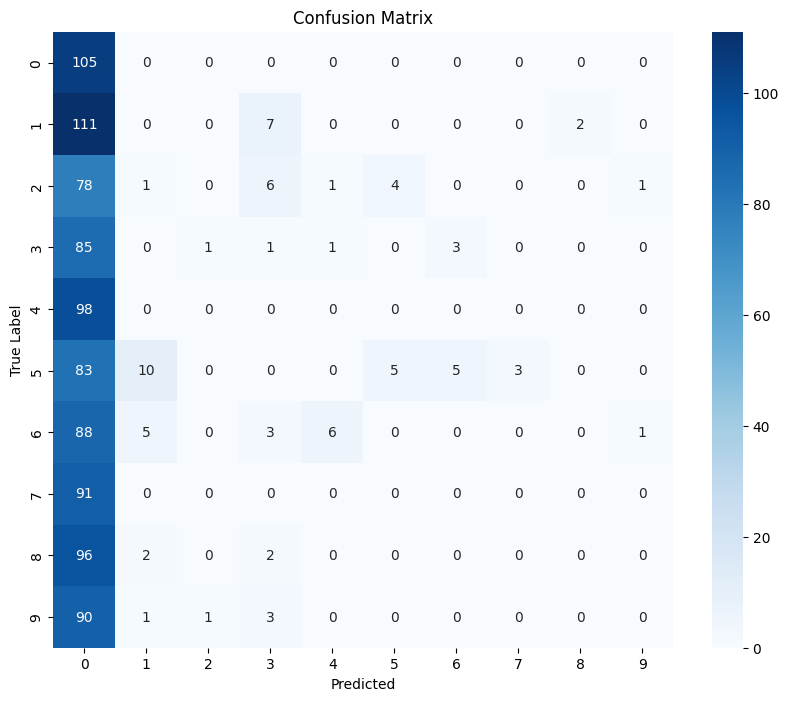

In [ ]:
val_predictions = model(x_val)
val_predictions_labels = np.argmax(val_predictions.numpy(), axis=1)
y_val_labels = np.argmax(y_val, axis=1)

accuracy = accuracy_score(y_val_labels, val_predictions_labels)
conf_matrix = confusion_matrix(y_val_labels, val_predictions_labels)

print(f"Validation Accuracy: {accuracy:.4f}")

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

**Diagonal Elements (proper categories are shown here): **

105 examples of class 0 were accurately categorised by the model.
It identified 111 occurrences of class 1 correctly.
While some of the projections in other classes are noticeably low, some are true.

**Off-Diagonal Elements (misclassifications displayed here): **

7 cases of class 1 were incorrectly identified as class 2 by the model.
Six cases of class 2 were incorrectly assigned to class 6.
Ten misclassifications occurred in class 5, with some cases being incorrectly assigned to different classes.

**Complete Performance: **

The model's overall validation accuracy of 0.1110, or roughly 11.10%, suggests that it is not operating at optimal levels. With ten classes (0–9), a random estimate would result in an accuracy of about 10%. As a result, the model's performance barely outperforms arbitrary guesswork.